dt=168

In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [5]:
ds = xr.open_zarr('/swot/SUM01/spencer/run_1week_orechunked.zarr')
#ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/run_6048.zarr')

In [6]:
ds = ds.isel(niter=slice(1,338))
#ds = ds.drop_sel(niter=-20000)
#ds = ds.isel(z0=3)
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)
#ds = ds.dropna('npart')
#ds.niter.min()

In [7]:
mask_roundx = abs(ds.x.diff('time')).max('time')
mask_roundy = abs(ds.y.diff('time')).max('time')
ds = ds.where(mask_roundx<30)
ds = ds.where(mask_roundy<30)
#ds = ds.dropna('npart')
mask = ds['u'].where(np.isfinite(ds['u']),0).all('time')
ds=ds.where(mask>0,0)

In [46]:
dt=168

In [47]:
u_slice = ds.u.drop('niter').isel(z0=3).isel(time=slice(168-dt,169+dt))
v_slice = ds.v.drop('niter').isel(z0=3).isel(time=slice(168-dt,169+dt))

In [48]:
#Calculate power spectrum in Lagrangian space
with ProgressBar():
    uhat2 = xrft.power_spectrum(u_slice,dim='time', window=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(v_slice,dim='time', window=True).compute()#, detrend='linear'
ekehat = .5*(uhat2 + vhat2)

[####                                    ] | 10% Completed |  2.0s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 23.4s
[###                                     ] | 8% Completed |  2.0s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 27.6s


In [49]:
spec0 = int((ekehat['freq_time'].size-1)/2)

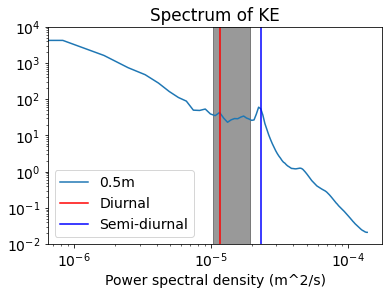

In [50]:
#Plot Lagrangian power spectrum
f1 = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
f2 = 2*2*np.pi/24/3600*np.sin(-26.6*np.pi/180)
(ekehat).mean(['x0','y0'])[spec0:].plot(label='0.5m')
#(ekehat.isel(z0=2).where(mask.isel(z0=2)>0)).mean(['x0','y0'])[spec0:].plot(label='15m')
#(ekehat.isel(z0=1).where(mask.isel(z0=1)>0)).mean(['x0','y0'])[spec0:].plot(label='50m')
#(ekehat.isel(z0=0).where(mask.isel(z0=0)>0)).mean(['x0','y0'])[spec0:].plot(label='200m')

plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)
plt.xlabel('Power spectral density (m^2/s)')

fig=plt.gcf()
fig.savefig('agulhas_spectrum_lagrang.png')

In [51]:
u_point = u_slice.isel(y0=1000).isel(x0=1000)

In [52]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [53]:
def lanczos(x, a):
    return np.sinc(x/a)

In [63]:
# sig = 8 is a pretty wide window. Maybe use this to decide total run length
# sig = 1.5 is probably vigorous enough to be useful
window_width=30
#weight = xr.DataArray(gaussian(np.arange(-window_width/2,window_width/2), 0, 8), dims=['window'])
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
windowed_u_point = u_point.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)

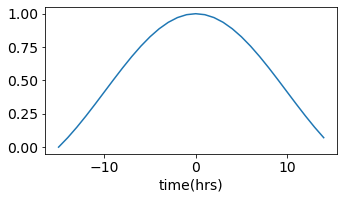

In [64]:
plt.figure(figsize=(5,3))
weight_x = weight.assign_coords(time=('window',np.arange(-window_width/2,window_width/2)))
weight_x.plot(x='time')
plt.xlabel('time(hrs)')
plt.tight_layout()
fig=plt.gcf()
fig.savefig('gaussian_filter_8hr.png')

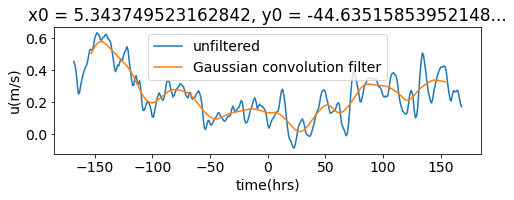

In [65]:
plt.figure(figsize=(7,3))
u_point_plotting = u_point.copy()
u_point_plotting['time'] = u_point['time']/3600
u_point_plotting.plot(label='unfiltered')
windowed_u_point_plotting = windowed_u_point.copy()
windowed_u_point_plotting['time'] = windowed_u_point['time']/3600
windowed_u_point_plotting.plot(label='Gaussian convolution filter')
plt.ylabel('u(m/s)')
plt.xlabel('time(hrs)')
plt.legend()
plt.tight_layout()
fig=plt.gcf()
fig.savefig('u_point_gaussian_filter.png')

In [66]:
windowed_u = u_slice.rolling(time=window_width, center=True
                            ).construct('window').dot(weight).sel(time = slice((-spec0+window_width/2)*3600,(spec0-window_width/2)*3600))/np.sum(weight)
windowed_v = v_slice.rolling(time=window_width, center=True
                            ).construct('window').dot(weight).sel(time =  slice((-spec0+window_width/2)*3600,(spec0-window_width/2)*3600))/np.sum(weight)
apples_u = u_slice.sel(time =  slice((-spec0+window_width/2)*3600,(spec0-window_width/2)*3600))
apples_v = v_slice.sel(time =  slice((-spec0+window_width/2)*3600,(spec0-window_width/2)*3600))

In [67]:
spec0

168

In [68]:
#Calculate power spectrum in Lagrangian space
with ProgressBar():
    uhat2_window = xrft.power_spectrum(windowed_u.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
    vhat2_window = xrft.power_spectrum(windowed_v.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
ekehat_window = .5*(uhat2_window + vhat2_window)

[###                                     ] | 8% Completed |  1.9s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 35.5s
[##                                      ] | 5% Completed |  1.7s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 41.1s


In [69]:
#Calculate power spectrum in Lagrangian space
with ProgressBar():
    uhat2_apples = xrft.power_spectrum(apples_u,dim='time', window=True).compute()#, detrend='linear'
    vhat2_apples = xrft.power_spectrum(apples_v,dim='time', window=True).compute()#, detrend='linear'
ekehat_apples = .5*(uhat2_apples + vhat2_apples)

[##                                      ] | 6% Completed |  1.9s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 34.8s
[####                                    ] | 11% Completed |  3.9s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 42.4s


In [70]:
specwin = int((ekehat_window['freq_time'].size-1)/2)

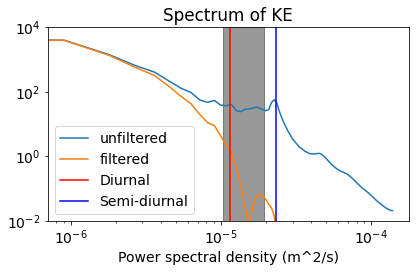

In [71]:
#Plot Lagrangian power spectrum
f1 = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
f2 = 2*2*np.pi/24/3600*np.sin(-26.6*np.pi/180)
(ekehat_apples).mean(['x0','y0'])[specwin:].plot(label='unfiltered')
(ekehat_window).mean(['x0','y0'])[specwin:].plot(label='filtered')
#(ekehat.isel(z0=2).where(mask.isel(z0=2)>0)).mean(['x0','y0'])[spec0:].plot(label='15m')
#(ekehat.isel(z0=1).where(mask.isel(z0=1)>0)).mean(['x0','y0'])[spec0:].plot(label='50m')
#(ekehat.isel(z0=0).where(mask.isel(z0=0)>0)).mean(['x0','y0'])[spec0:].plot(label='200m')

plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)
plt.xlabel('Power spectral density (m^2/s)')
plt.tight_layout()

fig=plt.gcf()
fig.savefig('agulhas_spectrum_lagrang_filterlanczos.png')

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


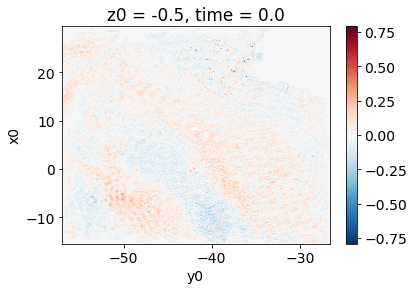

In [72]:
(apples_u.sel(time=0)-windowed_u.sel(time=0)).plot()

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


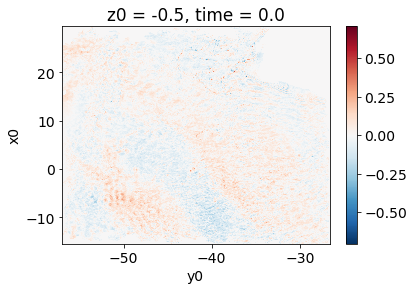

In [138]:
(apples_u.sel(time=0)-windowed_u.sel(time=0)).plot()

In [139]:
save_168 = (apples_u.sel(time=0)-windowed_u.sel(time=0))

In [7]:
dt=168
dt2=48
z_level=3
with ProgressBar():
    uhat_14day = xrft.dft(ds.u.drop('niter').isel(z0=z_level).isel(time=slice(168-dt,169+dt)),dim='time').compute()#, window=True
    uhat_2day = xrft.dft(ds.u.drop('niter').isel(z0=z_level).isel(time=slice(168-dt2,169+dt2)),dim='time', window=True).compute()

[                                        ] | 0% Completed |  0.0s

/home/spencerj/xrft/xrft/xrft.py:300: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


[##                                      ] | 6% Completed |  3.8s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 55.8s


/home/spencerj/xrft/xrft/xrft.py:300: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


[##                                      ] | 6% Completed |  4.1s

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 50.8s


In [8]:
uhat_labeled14 = uhat_14day.assign_coords({"min_lat":ds.y.isel(z0=z_level).min('time')})
uhat_labeled2 = uhat_2day.assign_coords({"min_lat":ds.y.isel(z0=z_level).min('time')})
f_local = 2*2*np.pi/24/3600*np.sin(uhat_labeled14.min_lat*np.pi/180)
f_local = 2*2*np.pi/24/3600*np.sin(uhat_labeled2.min_lat*np.pi/180)
maxfreq_local = (-f_local/2/np.pi)*0.9

In [9]:
spec0_14 = int((uhat_labeled14['freq_time'].size-1)/2)
spec0_2 = int((uhat_labeled2['freq_time'].size-1)/2)

In [10]:
spec_cut14 = (uhat_labeled14.freq_time[spec0_14:]<maxfreq_local).argmin('freq_time').values+spec0_14
spec_cut2 = (uhat_labeled2.freq_time[spec0_2:]<maxfreq_local).argmin('freq_time').values+spec0_2

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [30]:
locfiltered_14 = (uhat_labeled14.where(abs(uhat_labeled14.freq_time)<maxfreq_local))
locfiltered_2 = (uhat_labeled2.where(abs(uhat_labeled2.freq_time)<maxfreq_local))

In [35]:
ulocfiltered_14 = xrft.idft(locfiltered_14.where(np.isfinite(locfiltered_14),0),dim='freq_time').compute()#, window=True
ulocfiltered_2 = xrft.idft(locfiltered_2.where(np.isfinite(locfiltered_2),0),dim='freq_time').compute()#, window=True
#utransform_back = xrft.idft(uhat_14day.where(np.isfinite(locfiltered_14),0),dim='freq_time').compute()#, window=True

/home/spencerj/xrft/xrft/xrft.py:475: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.idft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider using xrft.ifft to ensure future compatibility with numpy.ifft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/xrft/xrft/xrft.py:475: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.idft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider using xrft.ifft to ensure future compatibility with numpy.if

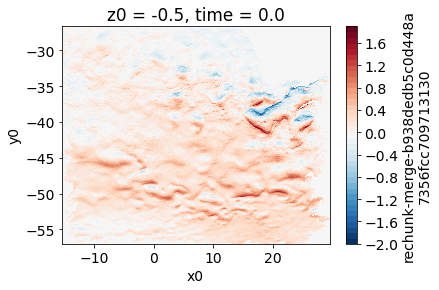

In [25]:
((ulocfiltered_14.sel(time=0).real)).plot(x='x0',levels=np.arange(-2,2,0.1))

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


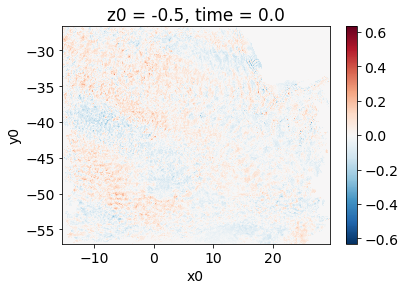

In [27]:
(ds.u.drop('niter').isel(z0=z_level).sel(time=0)-(ulocfiltered_14.sel(time=0).real)).plot(x='x0')

/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/dev_xrft/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


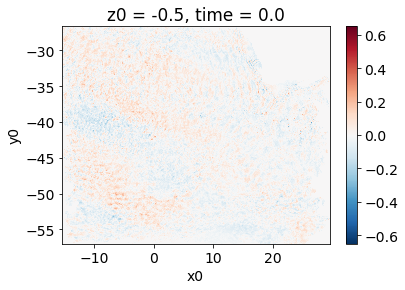

In [36]:
(ds.u.drop('niter').isel(z0=z_level).sel(time=0)-(ulocfiltered_2.sel(time=0).real)).plot(x='x0')

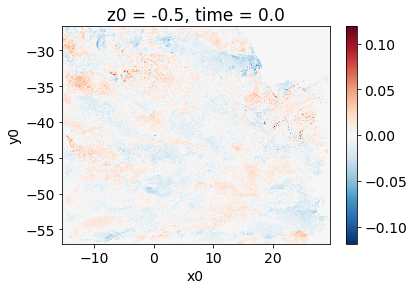

In [37]:
((ulocfiltered_2.sel(time=0).real)-(ulocfiltered_14.sel(time=0).real)).plot(x='x0')

In [57]:
# Pause here as idft PR would be helpful and is near to being merged.

<xarray.DataArray 'min_lat' (x0: 2160, y0: 2160)>
dask.array<mul, shape=(2160, 2160), dtype=float64, chunksize=(180, 180), chunktype=numpy.ndarray>
Coordinates:
  * x0                 (x0) float64 -15.49 -15.47 -15.45 ... 29.45 29.47 29.49
  * y0                 (y0) float64 -57.0 -56.99 -56.98 ... -26.69 -26.68 -26.66
    z0                 float64 -0.5
    freq_time_spacing  float64 2.864e-06
    min_lat            (x0, y0) float64 dask.array<chunksize=(180, 180), meta=np.ndarray>

In [100]:
xrft.power_spectrum(ds.u.drop('niter').isel(z0=z_level).sel(time=0).chunk({'x0':-1}),dim=['x0'], window=True)

<xarray.DataArray 'rechunk-merge-ade9591a177ebcf9df42622243c4fc59' (freq_x0: 2160, y0: 2160)>
dask.array<truediv, shape=(2160, 2160), dtype=float64, chunksize=(2160, 180), chunktype=numpy.ndarray>
Coordinates:
  * y0               (y0) float64 -57.0 -56.99 -56.98 ... -26.69 -26.68 -26.66
    z0               float64 -0.5
    time             float64 0.0
  * freq_x0          (freq_x0) float64 -24.0 -23.98 -23.95 ... 23.93 23.95 23.98
    freq_x0_spacing  float64 0.02222